OJO: one-hot funciona bien en general, aunque si pusiera label encoder en ciertas variables en las que usé one-hot podría ser mejorpara arboles

OJO2: si los modelos son un cagarro, corregir colver a data_cleaning y corregir class imbalance puede ayudar

In [1]:
%matplotlib inline
!pip install tensorflow
!pip install keras-tuner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler


C:\Users\fenan\AppData\Local\Temp\ipykernel_9176\1764454611.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [99]:
df = pd.read_csv('clean_and_encoded_df.csv')

# Aplicar logaritmo a la variable 'Annual_salary'
df['Annual_salary'] = np.sqrt(df['Annual_salary'])

# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep = [col for col in df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_df = df[columns_to_keep]


baseline_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Andorra,Country_Angola,Country_Argentina,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,4.8,200.511845
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,6.4,229.715041
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,232.432786
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.8,268.780580
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,11.4,250.639183


In [100]:
base_X = baseline_df.drop('Annual_salary', axis=1)
y = baseline_df['Annual_salary']
print(base_X.shape)
print(y.shape)

(2805, 138)
(2805,)


In [101]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(base_X, y, test_size=0.2, random_state=42)
y_train = y_train.reset_index(drop=True)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [102]:

k = 5
num_val_samples = len(X_train_scaled) // k
num_epochs = 8
train_loss_history = []
val_loss_history = []

all_scores_r2 = []
all_scores_adjusted_r2 = []
all_scores_rmse = []
all_scores_mae = []

#es = EarlyStopping(monitor='val_loss', mode='min', patience=2)


for i in range(k):
    print('processing fold #', i)
    val_data = X_train_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [X_train_scaled[:i * num_val_samples],
         X_train_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(partial_train_data.shape[1],)))
    model.add(Dropout(0.2))  # Capa Dropout agregada aquí
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))  # Capa Dropout agregada aquí
    model.add(Dense(32, activation='relu')) # Extra layer
    model.add(Dropout(0.2))  # Capa Dropout agregada aquí
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Nadam(learning_rate=0.001), loss='mse', metrics=['mae'])

    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=8, verbose=0, validation_data=(val_data, val_targets))

    train_loss_history.append(history.history['loss'])
    val_loss_history.append(history.history['val_loss'])

    val_preds = model.predict(val_data)
    # Reverse sqrt transformation
    val_preds_sqrd = val_preds**2 
    val_targets_sqrd = val_targets**2 

    r2_val = r2_score(val_targets_sqrd, val_preds_sqrd)
    n = val_data.shape[0]
    p = val_data.shape[1]
    adjusted_r2_val = 1 - (1 - r2_val) * (n - 1) / (n - p - 1)
    rmse_val = np.sqrt(mean_squared_error(val_targets_sqrd, val_preds_sqrd))
    mae_val = mean_absolute_error(val_targets_sqrd, val_preds_sqrd)

    all_scores_r2.append(r2_val)
    all_scores_adjusted_r2.append(adjusted_r2_val)
    all_scores_rmse.append(rmse_val)
    all_scores_mae.append(mae_val)


mean_r2 = np.mean(all_scores_r2)
std_r2 = np.std(all_scores_r2)
mean_adjusted_r2 = np.mean(all_scores_adjusted_r2)
std_adjusted_r2 = np.std(all_scores_adjusted_r2)
mean_rmse = np.mean(all_scores_rmse)
std_rmse = np.std(all_scores_rmse)
mean_mae = np.mean(all_scores_mae)
std_mae = np.std(all_scores_mae)

print(f"Rendimiento promedio R2 (XGBoost): {mean_r2:.3f} (+/- {std_r2:.3f})")
print(f"Rendimiento promedio R2 ajustado (XGBoost): {mean_adjusted_r2:.3f} (+/- {std_adjusted_r2:.3f})")
print(f"Rendimiento promedio RMSE (XGBoost): {mean_rmse:.3f} (+/- {std_rmse:.3f})")
print(f"Rendimiento promedio MAE (XGBoost): {mean_mae:.3f} (+/- {std_mae:.3f})")



processing fold # 0
14/14 [==============================] - 0s 2ms/step
processing fold # 1
14/14 [==============================] - 0s 2ms/step
processing fold # 2
14/14 [==============================] - 0s 3ms/step
processing fold # 3
14/14 [==============================] - 0s 3ms/step
processing fold # 4
14/14 [==============================] - 0s 2ms/step
Rendimiento promedio R2 (XGBoost): 0.534 (+/- 0.035)
Rendimiento promedio R2 ajustado (XGBoost): 0.325 (+/- 0.051)
Rendimiento promedio RMSE (XGBoost): 34496.146 (+/- 1520.229)
Rendimiento promedio MAE (XGBoost): 24933.774 (+/- 803.434)


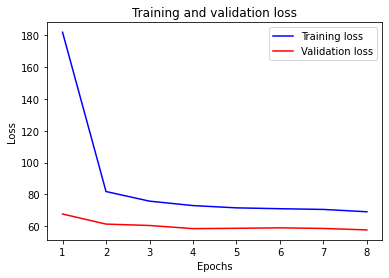

In [103]:
average_train_loss_history = np.mean(np.sqrt(train_loss_history), axis=0)
average_val_loss_history = np.mean(np.sqrt(val_loss_history), axis=0)

plt.plot(range(1, num_epochs + 1), average_train_loss_history, 'b', label='Training loss')
plt.plot(range(1, num_epochs + 1), average_val_loss_history, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Hyperparameters:

- 12 epochs

In [7]:
'''# Build the model
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=256, step=32),
                    activation='relu', input_shape=(X_train_scaled.shape[1],)))
    
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'units_layer{i}', min_value=32, max_value=256, step=32),
                        activation='relu'))
    
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')),
                  loss='mse', metrics=['mae'])
    
    return model

# Initialize the RandomSearch tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld'
)

tuner.search_space_summary()

# Perform the search for hyperparameters
tuner.search(X_train_scaled, y_train, epochs=100, validation_split=0.2, verbose=0)

tuner.results_summary()

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model with your data
best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print(f"Los mejores hiperparámetros encontrados son:\n {best_hyperparameters.values}")
'''
'''El mejor conjunto de hiperparámetros encontrado en la búsqueda aleatoria es:

units_input: 32
num_layers: 4
units_layer0: 192
learning_rate: 0.0006999996898188677
units_layer1: 32
units_layer2: 256
units_layer3: 192'''

'El mejor conjunto de hiperparámetros encontrado en la búsqueda aleatoria es:\n\nunits_input: 32\nnum_layers: 4\nunits_layer0: 192\nlearning_rate: 0.0006999996898188677\nunits_layer1: 32\nunits_layer2: 256\nunits_layer3: 192'

In [8]:
'''average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
val_average_mae_history = [
    np.mean([x[i] for x in val_all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.plot(range(1, len(val_average_mae_history) + 1), val_average_mae_history)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.xlim(1, 15)
plt.legend(['training', 'validation'])
plt.show()'''

"average_mae_history = [\n    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]\nval_average_mae_history = [\n    np.mean([x[i] for x in val_all_mae_histories]) for i in range(num_epochs)]\n\nplt.plot(range(1, len(average_mae_history) + 1), average_mae_history)\nplt.plot(range(1, len(val_average_mae_history) + 1), val_average_mae_history)\nplt.title('Training and validation loss')\nplt.xlabel('Epochs')\nplt.ylabel('MAE')\nplt.xlim(1, 15)\nplt.legend(['training', 'validation'])\nplt.show()"

In [104]:
mlp_results_dic = {}

mlp_results_dic['MLP'] = {'R2': mean_r2, 'Adj R2': mean_adjusted_r2, 'RMSE': mean_rmse, 'MAE': mean_mae}
mlp_results  = pd.DataFrame.from_dict(mlp_results_dic, orient='index')
mlp_results

,R2,Adj R2,RMSE,MAE
MLP,0.533583,0.325281,34496.146215,24933.773547


In [105]:
mlp_results.to_csv('sqrt_mlp_results.csv', index=True)

In [106]:
# Combinar conjuntos de datos de entrenamiento y validación
X_train_val = np.concatenate((X_train_scaled, val_data), axis=0)
y_train_val = np.concatenate((y_train, val_targets), axis=0)

# Entrenar el modelo utilizando el conjunto de datos combinado
model.fit(X_train_val, y_train_val)

# Hacer predicciones en el conjunto de datos de prueba
y_pred = model.predict(X_test_scaled)

# Revertir la transformación logarítmica
y_pred_sqrd = y_pred**2 #np.exp(y_pred)
y_test_sqrd = y_test**2 #np.exp(y_test)

# Calcular métricas de rendimiento en el conjunto de datos de prueba
r2_test = r2_score(y_test_sqrd, y_pred_sqrd)
rmse_test = np.sqrt(mean_squared_error(y_test_sqrd, y_pred_sqrd))
mae_test = mean_absolute_error(y_test_sqrd, y_pred_sqrd)
n_test = len(X_test_scaled)
p_test = X_train_val.shape[1]
adjusted_r2_test = 1 - (1 - r2_test) * (n_test - 1) / (n_test - p_test - 1)

print(f"Rendimiento R2 en el conjunto de prueba (MLR): {r2_test:.3f}")
print(f"Rendimiento adjusted R2 en el conjunto de prueba (MLR): {adjusted_r2_test:.3f}")
print(f"Rendimiento RMSE en el conjunto de prueba (MLR): {rmse_test:.3f}")
print(f"Rendimiento MAE en el conjunto de prueba (MLR): {mae_test:.3f}")

18/18 [==============================] - 0s 2ms/step
Rendimiento R2 en el conjunto de prueba (MLR): 0.570
Rendimiento adjusted R2 en el conjunto de prueba (MLR): 0.429
Rendimiento RMSE en el conjunto de prueba (MLR): 33263.201
Rendimiento MAE en el conjunto de prueba (MLR): 23183.745


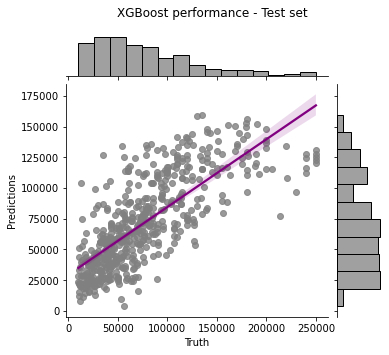

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear una cuadrícula de gráficos conjunta y configurar los ejes para los histogramas
g = sns.JointGrid(x=y_test_sqrd, y=y_pred_sqrd.squeeze(), height=5)

# Crear un gráfico de dispersión y ajustar una línea de regresión lineal a los datos
g.plot_joint(sns.regplot, scatter_kws={'color': 'grey'}, line_kws={'color': 'purple'})

# Agregar histogramas en la parte superior y en el lado derecho del gráfico
g.plot_marginals(sns.histplot, kde=False, color='grey')

# Ajustar el espacio entre los subgráficos y mover el título hacia arriba
g.fig.subplots_adjust(top=0.9)

# Agregar título
g.fig.suptitle("XGBoost performance - Test set")

# Etiquetar los ejes
g.ax_joint.set_xlabel("Truth")
g.ax_joint.set_ylabel("Predictions")

plt.show()